Imports

In [1]:
# Install extra dependencies
!pip install -q torchinfo accelerate tqdm

import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra

# pytorch dependency
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch import Tensor

# HuggingFace accelerate library
from accelerate import Accelerator # (easy support for multiple GPU's, TPU, floating point 16s, which makes training much faster)

# displaying the pytorch architecture (makes prototyping the network easier, as it shows shapes)
from torchinfo import summary

# plotting the results
import matplotlib.pyplot as plt
import seaborn as sns 

# creatation and transformations for the dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from PIL import Image

from collections import defaultdict

from IPython.display import clear_output

# show nice progress bar
from tqdm.notebook import tqdm

from time import time

In [2]:
datapath = os.path.join("/kaggle", "input", "cityscapes-image-pairs", "cityscapes_data")

# setting up the datapaths
train_datapath = os.path.join(datapath, "train")
val_datapath = os.path.join(datapath, "val")
train_cs_datapath = os.path.join(datapath, "cityscapes_data", "train")
val_cs_datapath = os.path.join(datapath, "cityscapes_data", "val")

# list all, full datapaths for training and validation images and save them in these two variables
training_images_paths = [os.path.join(train_datapath, f) for f in os.listdir(train_datapath)]
validation_images_paths = [os.path.join(val_datapath, f) for f in os.listdir(val_datapath)]

# sanity check, how many images
print(f"size of training : {len(training_images_paths)}")
print(f"size of cityscapes training : {len(os.listdir(train_cs_datapath))}")
print(f"size of validation : {len(validation_images_paths)}")
print(f"size of cityscapes validation : {len(os.listdir(val_cs_datapath))}")

global_step = 0

size of training : 2975
size of cityscapes training : 2975
size of validation : 500
size of cityscapes validation : 500


In [4]:
!pip install --upgrade accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.3/324.3 kB 2.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.33.0
    Uninstalling accelerate-0.33.0:
      Successfully uninstalled accelerate-0.33.0


In [7]:
class CONFIG:
    # use the 16 bit floating point arithmetic (should speeds up training/inference)
    USE_MIXED_PRECISION = "fp16"    # other values possible, "fp16" or None

    # downscaling the images : to make the inference on kaggle faster and keep within reason on GPU there, 
    #                          I set it to 2 (so the image is scaled from (256,256) to (128, 128)), None 
    #                          keeps the original shape 
    DOWNSCALE = 1

    # Imagenet channelwise mean
    MEAN = [0.485, 0.456, 0.406]

    # imagenet, channelwise standard deviation
    STD = [0.229, 0.224, 0.225]

    # epsilon for DICE, IoU losses (now 1e-6, however in some papers set to 1)
    EXTRA_LOSS_EPS = 1e-6

    # style of plots, I find darkgrid nice for regular plots
    SNS_STYLE = "darkgrid"

    BATCH_SIZE = 8

    SINGLE_NETWORK_TRAINING_EPOCHS = 15

    CE_VS_DICE_EVAL_EPOCHS = 15

    DELTA_BETA = 0.2

cfg = CONFIG()    

# Create a HuggingFace Accelerate accelerator. This allows using multiple GPUs, TPUs or 
# mixed precision (like brain-float16 or 16bit floating points) which should make training/inference 
# faster
if cfg.USE_MIXED_PRECISION is not None:
    accelerator = Accelerator(mixed_precision=cfg.USE_MIXED_PRECISION)
else:
    accelerator = Accelerator()

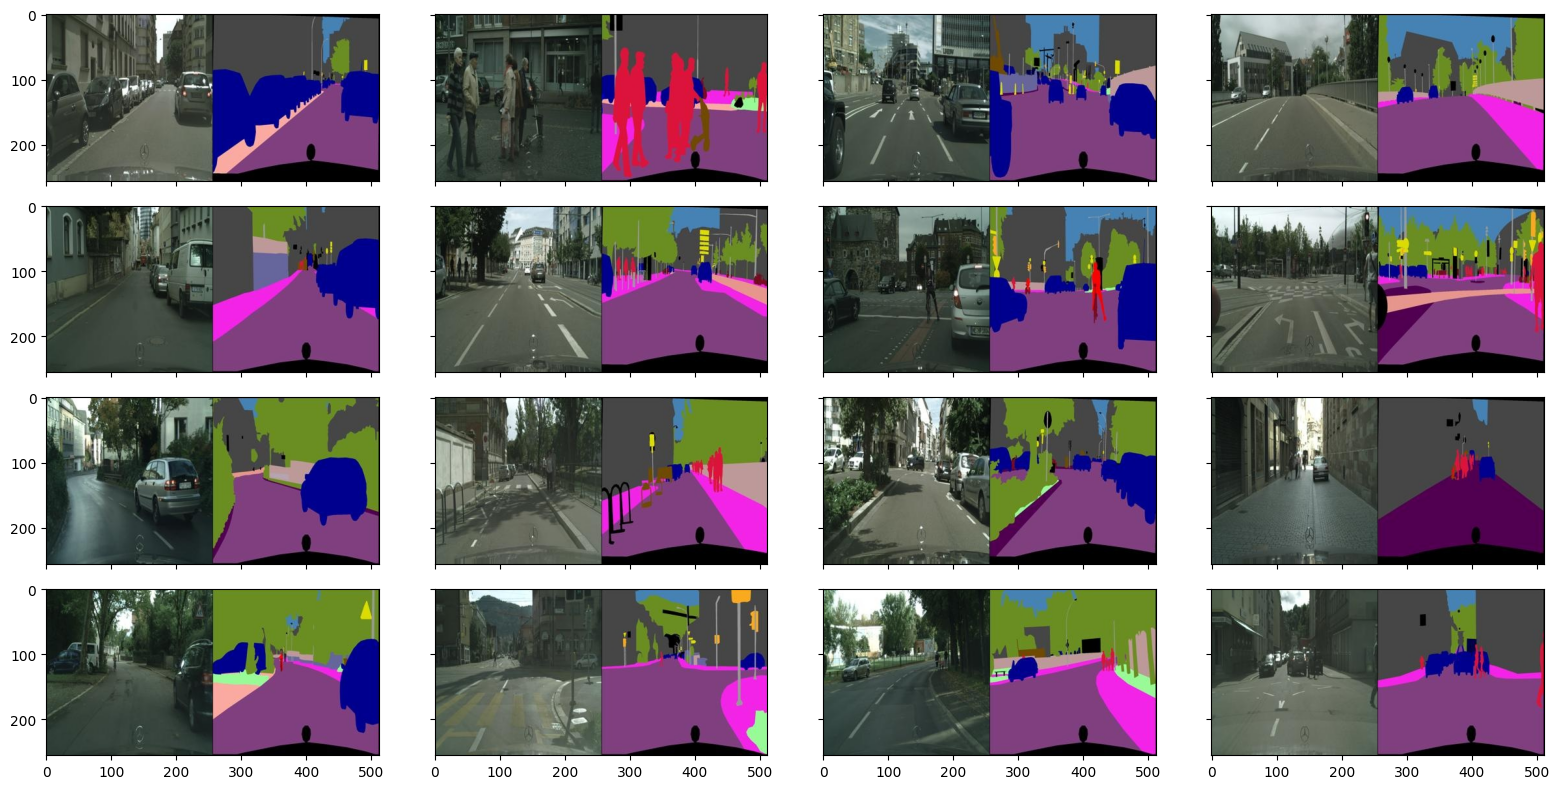

In [8]:
# how many images (total width * height)
width = 4
height = 4
vis_batch_size = width * height

# get vis_batch_size unique, random indices
indexes = np.arange(len(training_images_paths))
indexes = np.random.permutation(indexes)[:vis_batch_size]

# create the plot 
fig, axs = plt.subplots(height, width, sharex=True, sharey=True, figsize=(16, 8))
for i in range(vis_batch_size):
    # read the image
    img = torchvision.io.read_image(training_images_paths[indexes[i]])

    # pytorch reads it as (c, h, w), reshape it to (h, w, c) which is the shape matplotlib wants
    img = img.permute(1, 2, 0)
    
    # calculate the indexes for plots and set the image data
    y, x = i // width, i % width
    axs[y, x].imshow(img.numpy())
    
plt.tight_layout()

In [9]:
# reference
# link : https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
idx_to_name = [ 'unlabeled','ego vehicle','rectification border', 'out of roi', 'static', 'dynamic','ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence','guard rail' , 'bridge','tunnel','pole', 'polegroup', 'traffic light', 'traffic sign' ,'vegetation', 'terrain', 'sky' ,'person', 'rider', 'car','truck' ,'bus', 'caravan','trailer', 'train' , 'motorcycle','bicycle','license plate']
idx_to_category = ["void", "flat", "construction", "object", "nature", "sky", "human", "vehicle"]

idx_to_color = [[ 0,  0,  0], [ 0,  0,  0], [  0,  0,  0], [  0,  0,  0],[ 0,  0,  0],[111, 74,  0],[81,  0, 81] ,[128, 64,128],[244, 35,232],
                [250,170,160],[230,150,140],[70, 70, 70],[102,102,156],[190,153,153],[180,165,180],[150,100,100],[150,120, 90],[153,153,153],
                [153,153,153],[250,170, 30],[220,220,  0],[107,142, 35],[152,251,152],[ 70,130,180],[220, 20, 60],[255,  0,  0],[ 0,  0,142],
                [ 0,  0, 70],[ 0, 60,100],[ 0,  0, 90],[  0,  0,110],[ 0, 80,100],[  0,  0,230],[119, 11, 32],[  0,  0,142]]


idx_to_color_np = np.array(idx_to_color)

name_to_category = {0 : 0, 1 : 0, 2 : 0, 3: 0, 4 : 0, 5 : 0, 6 : 0, 7 : 1, 8 : 1, 9 : 1, 10 : 1, 11 :2, 12 : 2, 13 : 2, 14 : 2, 15 : 2, 16 : 2,
                    17 : 3, 18 : 3, 19 : 3, 20: 3, 21 : 4, 22 : 4, 23 : 5, 24 : 6, 25 : 6, 26 : 7, 27 : 7, 28 : 7, 29 : 7, 30 : 7, 31 : 7, 32: 7, 33 : 7, 34 : 7}

size of input :  (256, 256, 3)
size of mask raw :  (256, 256, 3)
size of classes :  (256, 256)


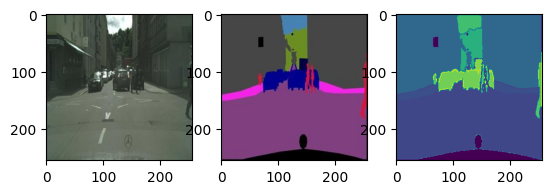

In [10]:
from typing import Tuple

# vectorize the operation of getting the name to category for numpy (just a lookup in name_to_category dictionary)
name_to_category_mapping = lambda x: name_to_category[x]
vectorized_cat_mapping = np.vectorize(name_to_category_mapping)

# vectorize the operation of mapping the name to color for numpy (just a lookup in idx_to_color dictionary)
name_to_col_mapping = lambda x: idx_to_color[x]
vectorized_col_mapping = np.vectorize(name_to_col_mapping)

def preprocess_image(path : str, sparse_mapping=True, downscale_factor=None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
        Read the .jpeg image from *path*. Return the input image (256 x 256 x 3), mask (256 x 256 x 3) read from the jpeg 
        and conversion to categories or names (if sparse_mapping is true) representation (256 x 256 x (|categories| or |names|) )
    """
    # Read the image from path and dowscale if downscale_factor is not None.
    img = Image.open(path)
    width, height = img.size

    if downscale_factor:
        width, height = width // downscale_factor, height//downscale_factor 
        img = img.resize(( width, height ))

    # then split the image into two images (in the middle of width) : input image and color mask (each represented by 3 channels)
    img = np.asarray(img)
    raw, mask = img[:, :width//2, :], img[:, width//2:, :]
    
    height, width, channels = mask.shape

    # compute then the sum of squared distances for each pixel to the colors (L2 between the color and pixel data) : 
    # the value which will be the minimal is the category name we will use for that pixel, and we will get it using argmin
    distances = np.sum((mask.reshape(-1, channels)[:, np.newaxis, :] - idx_to_color_np)**2, axis=2)
    classes = np.argmin(distances, axis=1).reshape(height, width)

    # if we want to operate on names, map the categories to names
    if sparse_mapping:
        classes = vectorized_cat_mapping(classes)
    
    return raw, mask, classes


x, mask_raw, classes = preprocess_image(training_images_paths[indexes[i]], sparse_mapping=False, downscale_factor=None)

# sanity checks and print the data
print("size of input : ", x.shape)
print("size of mask raw : ", mask_raw.shape)
print("size of classes : ", classes.shape)
plt.subplot(1, 3, 1)
plt.imshow(x)
plt.subplot(1, 3, 2)
plt.imshow(mask_raw)
plt.subplot(1, 3, 3)
plt.imshow(classes)
plt.show()

In [11]:
train_images_to_use = -1

# for kaggle
downscale_factor=cfg.DOWNSCALE

X_train, Y_train = [], []
X_val, Y_val = [], []

for path in tqdm(training_images_paths[:]):
    X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
    X_train.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_train.append(torch.Tensor(Y))

for path in tqdm(validation_images_paths):
    X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
    X_val.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_val.append(torch.Tensor(Y))

  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [12]:
print(f"size of X_train : {len(X_train)} ; Y_train {len(Y_train)}")
print(f"size of X_val : {len(X_val)} ; Y_val {len(Y_val)}")

size of X_train : 2975 ; Y_train 2975
size of X_val : 500 ; Y_val 500


In [13]:
# Pytorch Dataset
class CityScapesDataset(Dataset):
    def __init__(self, X, Y, transform=None, target_transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]

        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x , y
    
    
# just normalize the data
preprocess = transforms.Compose([
    transforms.Normalize(mean=cfg.MEAN, std=cfg.STD),
])

# create the Datasets
train_ds = CityScapesDataset(X_train, Y_train, transform=preprocess)
val_ds = CityScapesDataset(X_val, Y_val, transform=preprocess)

# create the dataloaders
train_dataloader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=True)

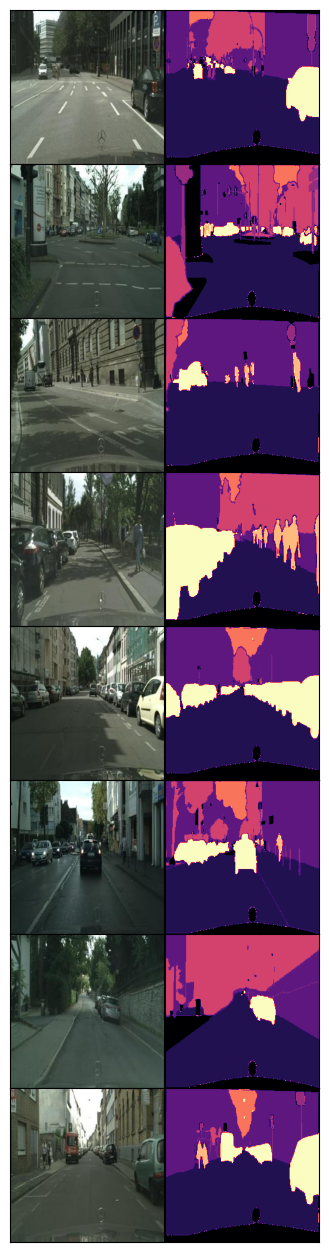

In [14]:
fig, axes = plt.subplots(cfg.BATCH_SIZE, 2, figsize=(4, 2.*cfg.BATCH_SIZE), squeeze=True)
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(cfg.BATCH_SIZE):
    img, mask = X_train[i], Y_train[i]  
    #print(img.shape, mask.shape)
    axes[i, 0].imshow(img.permute(1,2, 0))
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    
    axes[i, 1].imshow(mask, cmap='magma')
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])

torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])


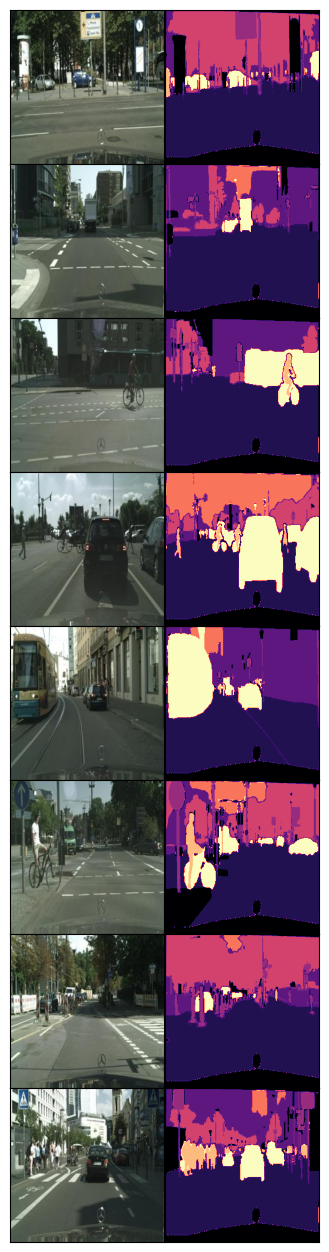

In [15]:
eval_batch_data = next(iter(val_dataloader))

# the images coming from the dataset are now preprocessed : 
# images are normalized using means and standard deviations coming from ImageNet (x' = (x - \mu) / \std)
# to decode, multiply by standard deviation, and add mean (x = x' * \std + \mu)

def decode_image(img : torch.Tensor) -> torch.Tensor:
    return img * torch.Tensor(cfg.STD) + torch.Tensor(cfg.MEAN)

print(eval_batch_data[0].shape, eval_batch_data[1].shape)
batch_size = eval_batch_data[0].shape[0]
fig, axes = plt.subplots(batch_size, 2, figsize=(4, 2.*batch_size), squeeze=True)
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(batch_size):
    img, mask = eval_batch_data[0][i], eval_batch_data[1][i]  
    #print(img.shape, mask.shape)
    axes[i, 0].imshow(decode_image(img.permute(1,2, 0)))
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    
    axes[i, 1].imshow(mask, cmap='magma')
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])

In [18]:
i =5
img, mask = eval_batch_data[0][i], eval_batch_data[1][i]
mask.shape

torch.Size([256, 256])

In [19]:
# dice loss
# awesome implementation for DICE can be found here
# https://github.com/milesial/Pytorch-UNet/blob/master/utils/dice_score.py
def dice_coeff(inp : Tensor, tgt : Tensor, eps=cfg.EXTRA_LOSS_EPS):
    sum_dim = (-1, -2, -3)

    # calculation of intersection   
    inter = 2 *(inp * tgt).sum(dim=sum_dim)

    # calculate the sum of |inp| + |tgt|
    sets_sum = inp.sum(dim=sum_dim) + tgt.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    # calcaute the dice    
    dice = (inter + eps) / (sets_sum + eps)

    # average the dice of classwise
    return dice.mean()

def multiclass_dice_coeff(input: Tensor, target: Tensor, eps: float = cfg.EXTRA_LOSS_EPS):
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), eps)

def dice_loss(input: Tensor, target: Tensor):
    # Dice loss (objective to minimize) between 0 and 1
    return 1 - multiclass_dice_coeff(input, target)

def IoU_coeff(inp : Tensor, tgt : Tensor, eps = 1e-6):
    sum_dim = (-1, -2, -3)
    
    # Intersection term  |A ^ B|
    inter = (inp * tgt).sum(dim=sum_dim)
    
    # sum of |A| + |B|
    sets_sum = inp.sum(dim=sum_dim) + tgt.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)
    
    # IoU = |A ^ B| / |A \/ B| = |A ^ B| / (|A| + |B| - |A^B|)
    return (inter + eps) / (sets_sum - inter + eps)

def IoU_loss(inp : Tensor, tgt : Tensor):
    return 1 - IoU_coeff(inp.flatten(0,1), tgt.flatten(0,1))

def log_cosh_dice_loss(input: torch.Tensor, target: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    # Compute the Dice coefficient
    dice = dice_coeff(input, target)
    
    # Compute Dice loss
    dice_loss_value = 1 - dice
    
    # Apply Log-Cosh to the Dice loss
    return torch.log(torch.cosh(dice_loss_value + eps))

# **model**

In [20]:
def train_model(model, device, train_dataloader,
                val_dataloader, epochs=10, lr=1e-4, update_pb_every_batch=1,
                with_dice_loss=True, with_IoU_loss=False, with_log_cosh_dice_loss=False):
    global global_step

    # setup the optimizer, loss, learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    criterion = nn.CrossEntropyLoss()
    
    model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

    returned_data = []

    for epoch in range(1, epochs + 1):
        
        training_loss = 0
        training_dice = 0
        training_IoU = 0
        training_log_cosh_dice = 0
        with tqdm(train_dataloader, desc=f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss,3)}") as pbar:
            model.train()
            optimizer.zero_grad()
            examples_so_far = 0
            for i, batch in enumerate(train_dataloader):
                optimizer.zero_grad()
                images, true_masks = batch[0], batch[1]
                
                images = images.to(device)
                true_masks = true_masks.to(device).long()
                                
                masks_pred = model(images)
                
                loss = criterion(masks_pred, true_masks)
                if with_dice_loss:
                    dice = dice_loss(F.softmax(masks_pred, dim=1).float(),
                              F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
                    loss += dice
                    training_dice += images.shape[0] * (1. - dice.item())
                
                if with_IoU_loss:
                    IoU = IoU_loss(F.softmax(masks_pred, dim=1).float(),
                              F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
                    loss += IoU
                    training_IoU += images.shape[0] * (1. - IoU.item())

                if with_log_cosh_dice_loss:
                    log_cosh_dice = log_cosh_dice_loss(F.softmax(masks_pred, dim=1).float(),
                                                       F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
                    loss += log_cosh_dice
                    training_log_cosh_dice += images.shape[0] * log_cosh_dice.item()
                
                # Backward and optimize
                accelerator.backward(loss)
                optimizer.step()
                
                global_step += 1
                training_loss += images.shape[0] * loss.item()
                examples_so_far += images.shape[0]

                pbar.update(1)
                if i % update_pb_every_batch == 0:
                    descr = f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss / examples_so_far ,3)}"        
                    if with_dice_loss:
                        descr += f", avg DICE : {round(training_dice / examples_so_far ,3)}"
                    if with_IoU_loss:
                        descr += f", avg IoU : {round(training_IoU / examples_so_far ,3)}"
                    if with_log_cosh_dice_loss:
                        descr += f", avg Log-Cosh DICE : {round(training_log_cosh_dice / examples_so_far ,3)}"
                    
                    pbar.set_description(descr)
        
        epoch_summary = {}
        epoch_summary["training_loss"] = training_loss / examples_so_far
        if with_dice_loss:
            epoch_summary["training_DICE_coefficient"] = training_dice / examples_so_far
        if with_IoU_loss:
            epoch_summary["training_IoU_coefficient"] = training_IoU / examples_so_far
        if with_log_cosh_dice_loss:
            epoch_summary["training_log_cosh_DICE_coefficient"] = training_log_cosh_dice / examples_so_far

        val_summary = evaluate_model(model, val_dataloader, epoch, epochs, criterion, 
                                     with_dice_loss=with_dice_loss, with_IoU_loss=with_IoU_loss, 
                                     with_log_cosh_dice_loss=with_log_cosh_dice_loss)
        epoch_summary = {**epoch_summary, **val_summary}
        returned_data.append(epoch_summary)

    return returned_data


In [21]:
def evaluate_model(model, val_dataloader, epoch, epochs, criterion,
                   with_dice_loss=True, with_IoU_loss=False, with_log_cosh_dice_loss=False):
    global epoch_to_fig 
    val_loss = 0
    val_dice = 0
    val_IoU = 0
    val_log_cosh_dice = 0
    with tqdm(val_dataloader, desc=f"Epoch {epoch}/{epochs} ; val Loss 0") as pbar:
        model.eval()
        examples_so_far = 0
        for i, batch in enumerate(val_dataloader):
            images, true_masks = batch[0], batch[1]
                
            images = images.to(device)
            true_masks = true_masks.to(device).long()                
                
            # predictions
            masks_pred = model(images)
            
            loss = criterion(masks_pred, true_masks)
            val_loss += loss.item() * images.shape[0]
            examples_so_far += images.shape[0]

            dice = dice_loss(F.softmax(masks_pred, dim=1).float(),
                             F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
            
            if with_dice_loss:
                loss += dice
            val_dice += images.shape[0] * (1. - dice.item())
                
            IoU = IoU_loss(F.softmax(masks_pred, dim=1).float(),
                           F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
            
            if with_IoU_loss:
                loss += IoU
            val_IoU += images.shape[0] * (1. - IoU.item())

            if with_log_cosh_dice_loss:
                log_cosh_dice = log_cosh_dice_loss(F.softmax(masks_pred, dim=1).float(),
                                                   F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
                loss += log_cosh_dice
                val_log_cosh_dice += images.shape[0] * log_cosh_dice.item()
            
            pbar.update(1)
                
            descr = f"Epoch {epoch}/{epochs} ; val Loss {round(val_loss / examples_so_far ,3)}, val IoU : {round(val_IoU / examples_so_far ,3)}, val Dice : {round(val_dice / examples_so_far ,3)}"
            if with_log_cosh_dice_loss:
                descr += f", val Log-Cosh DICE : {round(val_log_cosh_dice / examples_so_far ,3)}"
            pbar.set_description(descr)

    eval_summary = {}
    eval_summary["validation_loss"] = val_loss / examples_so_far
    eval_summary["validation_DICE_coefficient"] = val_dice / examples_so_far
    eval_summary["validation_IoU_coefficient"] = val_IoU / examples_so_far
    if with_log_cosh_dice_loss:
        eval_summary["validation_log_cosh_DICE_coefficient"] = val_log_cosh_dice / examples_so_far

    return eval_summary


In [22]:
def show_inference(batch, predictions):

    batch_size = batch[0].shape[0]
    fig, axes = plt.subplots(batch_size, 3, figsize=(6, 2.*batch_size), squeeze=True, sharey=True, sharex=True)
    fig.subplots_adjust(hspace=0.05, wspace=0)

    for i in range(batch_size):
        img, mask = batch[0][i], batch[1][i]  

        axes[i, 0].imshow(decode_image(img.permute(1,2, 0)))
        axes[i,0].set_xticks([])
        axes[i,0].set_yticks([])
        if i == 0:
            axes[i, 0].set_title("Input Image")

        axes[i, 1].imshow(mask, cmap='magma')
        axes[i,1].set_xticks([])
        axes[i,1].set_yticks([])
        if i == 0:
            axes[i, 1].set_title("True Mask")

        predicted = predictions[i]
        predicted = predicted.permute(1, 2, 0)
        predicted = torch.argmax(predicted, dim=2)

        axes[i, 2].imshow(predicted.cpu(), cmap='magma')
        axes[i, 2].set_xticks([])
        axes[i, 2].set_yticks([])
        if i == 0:
            axes[i, 2].set_title("Predicted Mask")



In [23]:
def plot_losses_coeffs(training_val_summary):

    if cfg.SNS_STYLE is not None:
        sns.set(style=cfg.SNS_STYLE)

    training = defaultdict(list)
    validation = defaultdict(list)

    m = 0

    for epoch_summary in training_val_summary:
        keys = list(epoch_summary.keys())

        training_keys = [k for k in keys if k.startswith("training")]
        for k in training_keys:
            training[k[len("training")+1:]].append(epoch_summary[k])

        val_keys = [k for k in keys if k.startswith("validation")]
        for k in val_keys:
            validation[k[len("validation")+1:]].append(epoch_summary[k])

    fig, axes = plt.subplots(len(validation.keys()), 1, figsize=(10, 10), sharex=True)

    for i,k in enumerate(validation.keys()):

        if k in training:
            axes[i].plot(training[k], marker='o', linestyle='--', label="training", linewidth=3)


        if validation[k][-1] > validation[k][0]:
            best_idx = np.argmax(validation[k])
        else:
            best_idx = np.argmin(validation[k])
        
        best = validation[k][best_idx]

        axes[i].set_title(f"{k} (validation best : {round(best, 4)})", fontsize=14, fontweight="bold")
        axes[i].plot(validation[k], label="validation", marker='o', linestyle='--', linewidth=3)

        axes[i].plot([0, best_idx], [best, best], linewidth=2, linestyle="--", color='black', alpha=0.5)
        m = max(m, len(validation[k]))
        axes[i].legend()

    axes[-1].set_xticks(list(range(0, m)))
    axes[-1].set_xticklabels(list(range(1, m + 1)))
    sns.set(style="white")

In [24]:
class ConvBlock(nn.Module):
    """apply twice convolution followed by batch normalization and relu. Preserves the width and height of input"""
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        
        self.cn1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.activ1 = nn.ReLU(inplace=True)
        self.cn2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.activ2 = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.cn1(x)
        x = self.bn1(x)
        x = self.activ1(x)
        x = self.cn2(x)
        x = self.bn2(x)
        return self.activ2(x)

class DownScale(nn.Module):
    """Downscaling with maxpool then ConvBlock, transforming an input with (h, w, in_channels) to (h/2, w/2, out_channels)"""
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.block = ConvBlock(in_channels, out_channels)
    
    def forward(self, x):
        x = self.pool(x)
        x = self.block(x)
        return x
 

class UpScale(nn.Module):
    """apply upscaling and then convolution block transforming an input with (h,w,in_channels) to (2h, 2w, out_channels).
       Forward function also simplifies Unet propagation by taking two inputs : first one from constantly propagating (from upscaling)
       and the second one, which is the output from applying Downscale (first input is upscaled, then concatenated with second)"""
    
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = ConvBlock(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = ConvBlock(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is (batch, channel, height, width)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


In [25]:
class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, start=32, bilinear=False):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = ConvBlock(n_channels, start)
        self.down1 = DownScale(start, 2*start)
        self.down2 = DownScale(2*start, 4*start)
        self.down3 = DownScale(4*start, 8*start)
        
        factor = 2 if bilinear else 1
        self.down4 = DownScale(8*start, 16*start // factor)
        
        self.up1 = UpScale(16*start, 8*start // factor, bilinear)
        self.up2 = UpScale(8*start, 4*start // factor, bilinear)
        self.up3 = UpScale(4*start, 2*start // factor, bilinear)
        self.up4 = UpScale(2*start, start, bilinear)
        self.outc = nn.Conv2d(start, n_classes, kernel_size=1)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
!pip install ipywidgets

!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

!pip install tqdm --upgrade

from tqdm.notebook import tqdm
from tqdm import tqdm  # Use this for console-based progress bars


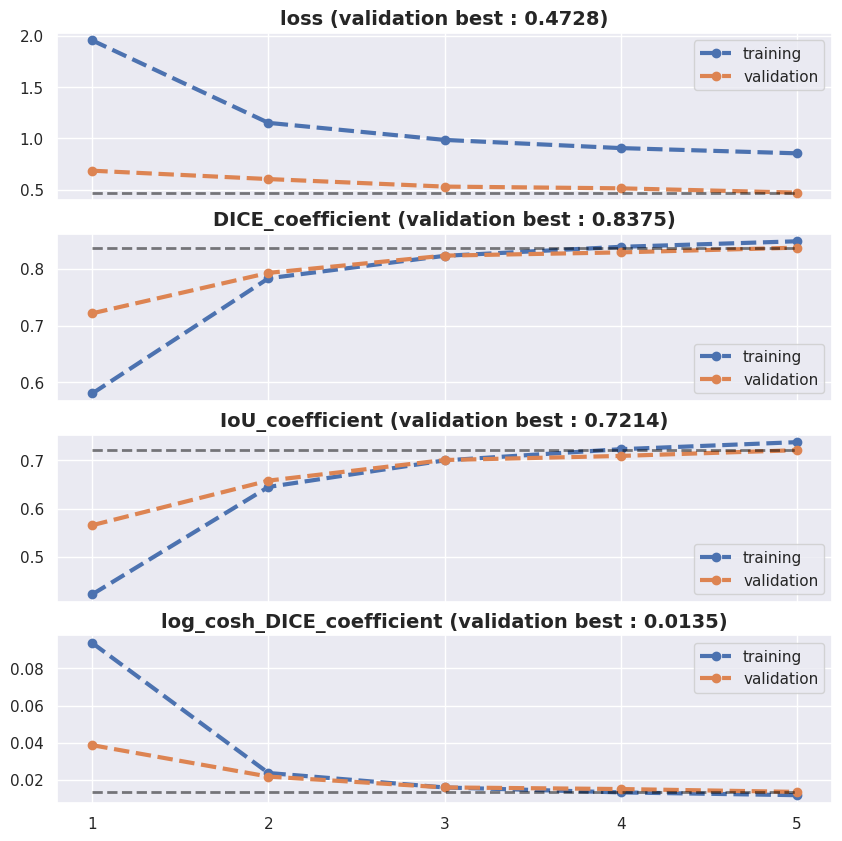

In [26]:
device = "cuda"
number_of_classes = len(set(name_to_category.values()))
model = Unet(3, number_of_classes)
model = model.to(device)

Unet_training_val_summary = train_model(model, device, train_dataloader, val_dataloader,
                                        lr=3e-4, epochs=5, update_pb_every_batch=10,
                                        with_dice_loss=True, with_IoU_loss=True, with_log_cosh_dice_loss=True)



clear_output(True)
plot_losses_coeffs(Unet_training_val_summary)


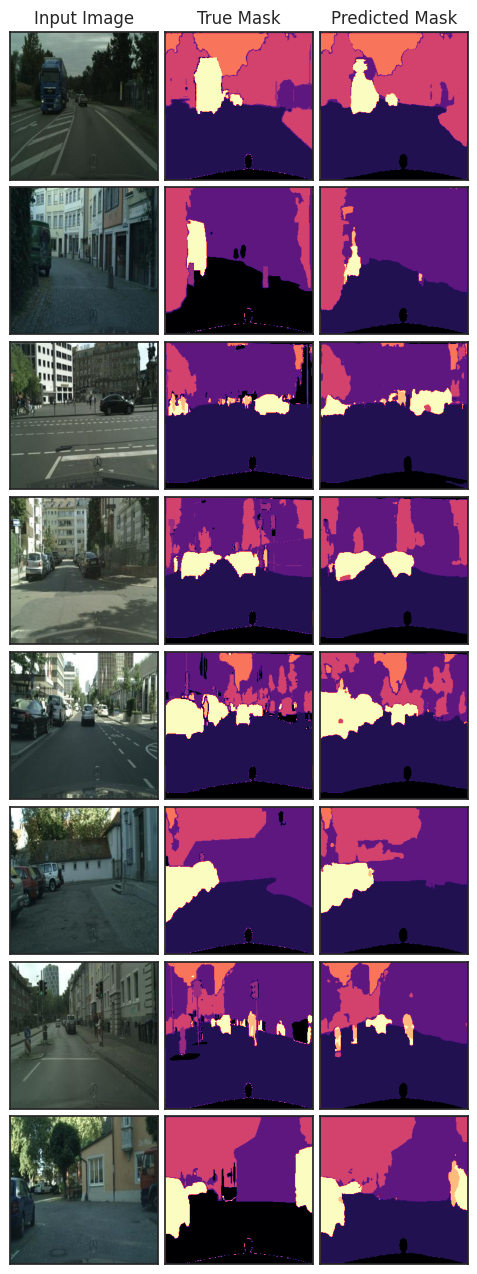

In [27]:
batch = next(iter(val_dataloader))
predictions = model(batch[0].to(device))
show_inference(batch, predictions)

In [28]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torch.nn as nn
import torchvision

resnet = resnet50(weights = ResNet50_Weights.DEFAULT)

class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """

        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UnetResNet50(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=2):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(weights = ResNet50_Weights.DEFAULT)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UnetResNet50.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UnetResNet50.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s] 


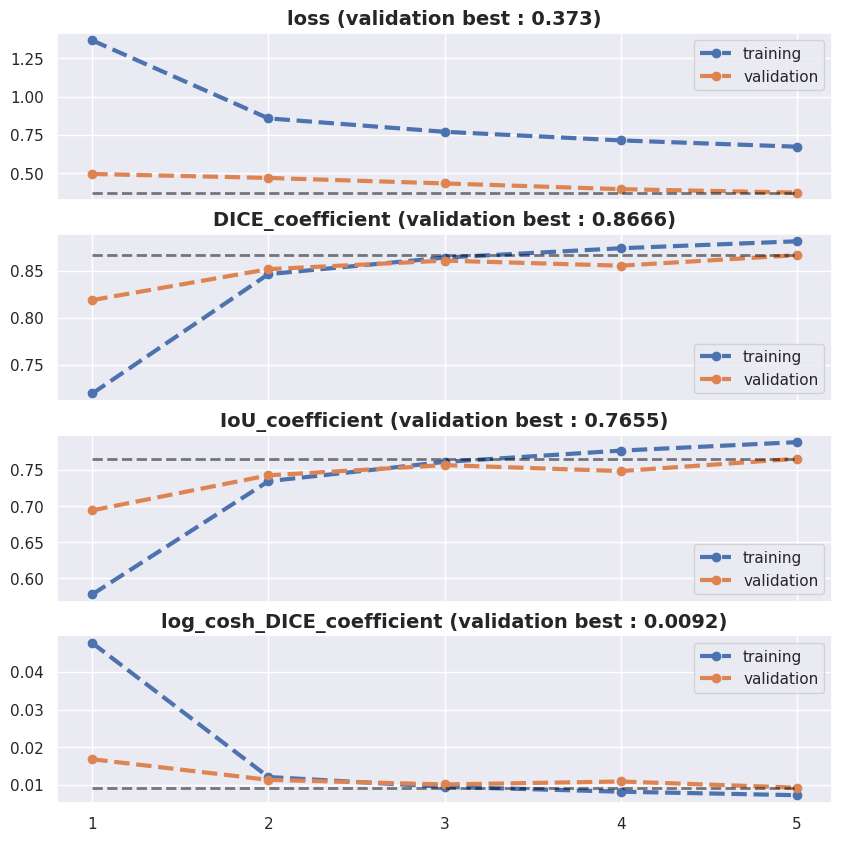

In [29]:
device = "cuda"
number_of_classes = len(set(name_to_category.values()))
resnet_Unet = UnetResNet50(number_of_classes)
resnet_Unet = resnet_Unet.to(device)

# Optional: Freeze initial layers for the first few epochs
for param in resnet_Unet.input_block.parameters():
    param.requires_grad = False
for param in resnet_Unet.down_blocks.parameters():
    param.requires_grad = False

Unet_training_val_summary = train_model(
    resnet_Unet, 
    device, 
    train_dataloader, 
    val_dataloader,
    lr=3e-4, 
    epochs=5, 
    update_pb_every_batch=10,
    with_dice_loss=True,          # Include Dice Loss
    with_IoU_loss=True,           # Include IoU Loss
    with_log_cosh_dice_loss=True  # Include Log-Cosh Dice Loss
)

clear_output(True)
plot_losses_coeffs(Unet_training_val_summary)


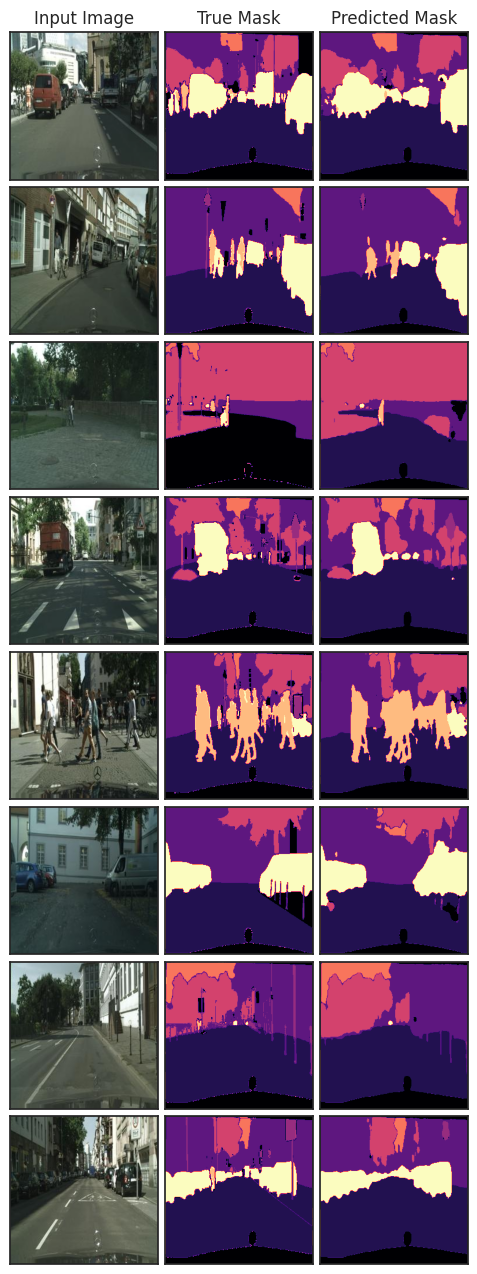

In [30]:
batch = next(iter(val_dataloader))
predictions = resnet_Unet(batch[0].to(device))
show_inference(batch, predictions)

In [44]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet50, ResNet50_Weights

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UpBlockWithAttention(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels, up_conv_in_channels=None, up_conv_out_channels=None, 
                 upsampling_method="conv_transpose", bilinear=True):
        super(UpBlockWithAttention, self).__init__()

        if up_conv_in_channels is None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels is None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2, align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        
        # Update F_g and F_l to reflect the correct channel sizes
        self.att = AttentionBlock(F_g=up_conv_out_channels, F_l=skip_channels, F_int=min(up_conv_out_channels, skip_channels))
        self.conv_block_1 = ConvBlock(up_conv_out_channels + skip_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        up_x = self.upsample(up_x)
        down_x = self.att(up_x, down_x)
        x = torch.cat([down_x, up_x], 1)  # Concatenate along the channel dimension
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x

class Bridge(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)

class AttentionUNetResNet50(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=2, bilinear=False):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(weights=ResNet50_Weights.DEFAULT)
        down_blocks = []
        up_blocks = []

        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)

        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        
        up_blocks.append(UpBlockWithAttention(2048, 1024, skip_channels=1024, upsampling_method="conv_transpose", bilinear=bilinear))
        up_blocks.append(UpBlockWithAttention(1024, 512, skip_channels=512, upsampling_method="conv_transpose", bilinear=bilinear))
        up_blocks.append(UpBlockWithAttention(512, 256, skip_channels=256, upsampling_method="conv_transpose", bilinear=bilinear))
        up_blocks.append(UpBlockWithAttention(256, 128, skip_channels=128, upsampling_method="conv_transpose", bilinear=bilinear))
        up_blocks.append(UpBlockWithAttention(128, 64, skip_channels=64, upsampling_method="conv_transpose", bilinear=bilinear))

        self.up_blocks = nn.ModuleList(up_blocks)
        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (AttentionUNetResNet50.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{AttentionUNetResNet50.DEPTH - 1 - i}"
            print(x.shape)
            print(pre_pools[key].shape)
            print(key)
            print(block)
            x = block(x, pre_pools[key])
            
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x


In [45]:
device = "cuda"
number_of_classes = len(set(name_to_category.values()))
attention_unet_resnet50 = AttentionUNetResNet50(number_of_classes)
attention_unet_resnet50 = attention_unet_resnet50.to(device)

# Call train_model with additional loss parameters
Unet_training_val_summary = train_model(
    attention_unet_resnet50, 
    device, 
    train_dataloader, 
    val_dataloader,
    lr=3e-4, 
    epochs=5, 
    update_pb_every_batch=10,
    with_dice_loss=True,          # Include Dice Loss
    with_IoU_loss=True,           # Include IoU Loss
    with_log_cosh_dice_loss=True  # Include Log-Cosh Dice Loss
)

clear_output(True)
plot_losses_coeffs(Unet_training_val_summary)


Epoch 1/5 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 72.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 4.12 MiB is free. Process 2281 has 14.73 GiB memory in use. Of the allocated memory 14.59 GiB is allocated by PyTorch, and 19.12 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import torch
import torch.nn as nn

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UpScaleAttention(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(UpScaleAttention, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        
        self.att = AttentionBlock(F_g=in_channels // 2, F_l=out_channels, F_int=out_channels // 2)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x2 = self.att(x1, x2)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class AttentionUNet(nn.Module):
    def __init__(self, n_channels, n_classes, start=32, bilinear=False):
        super(AttentionUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = ConvBlock(n_channels, start)
        self.down1 = DownScale(start, 2*start)
        self.down2 = DownScale(2*start, 4*start)
        self.down3 = DownScale(4*start, 8*start)
        
        factor = 2 if bilinear else 1
        self.down4 = DownScale(8*start, 16*start // factor)
        
        self.up1 = UpScaleAttention(16*start, 8*start // factor, bilinear)
        self.up2 = UpScaleAttention(8*start, 4*start // factor, bilinear)
        self.up3 = UpScaleAttention(4*start, 2*start // factor, bilinear)
        self.up4 = UpScaleAttention(2*start, start, bilinear)
        self.outc = nn.Conv2d(start, n_classes, kernel_size=1)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
device = "cuda"
number_of_classes = len(set(name_to_category.values()))
AttentionUNet = AttentionUNet(3,number_of_classes)
AttentionUNet = AttentionUNet.to(device)

Unet_training_val_summary = train_model(AttentionUNet, device, train_dataloader, val_dataloader,
                                        lr=3e-4, epochs=5, update_pb_every_batch=10)

clear_output(True)
plot_losses_coeffs(Unet_training_val_summary)